<a href="https://colab.research.google.com/github/PritikaSabharwal/Social-Media-Sentiment-Analysis-using-ML/blob/master/source_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

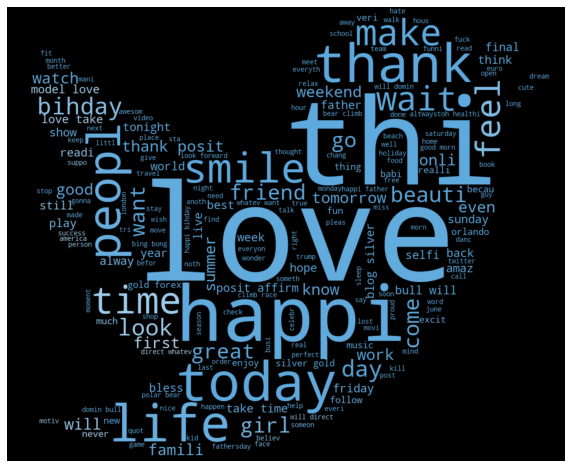

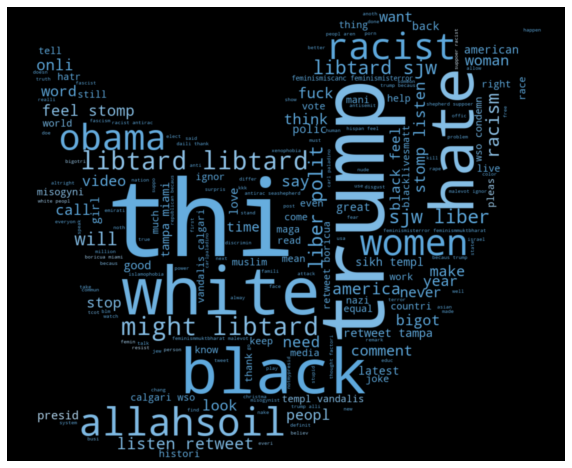

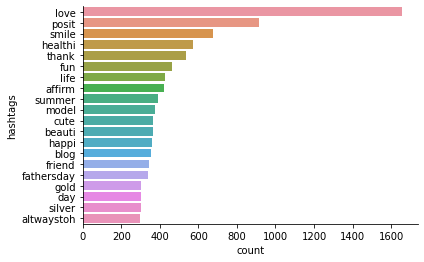

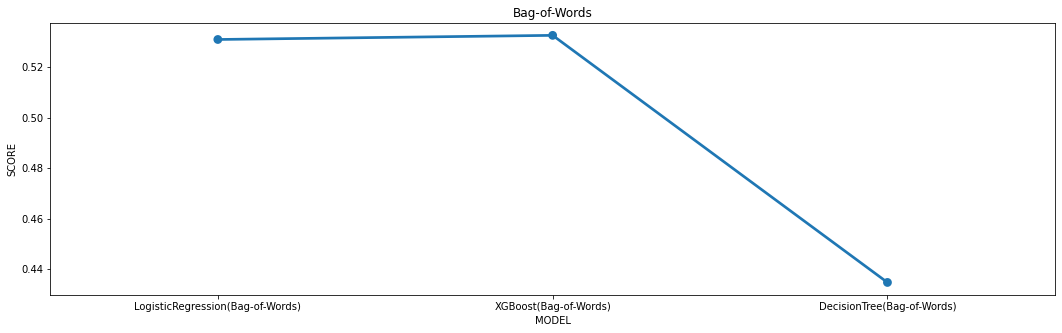

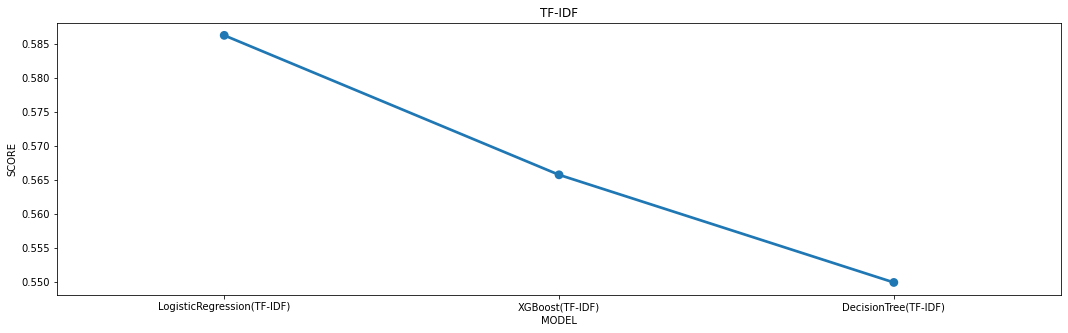

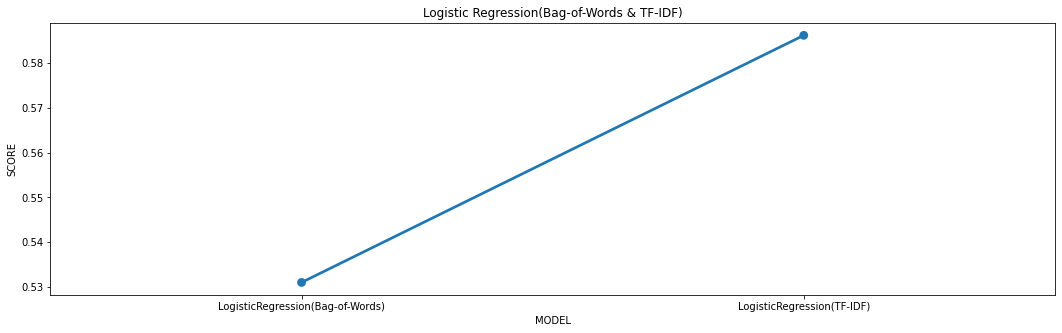

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0


In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline
train = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')
train_original=train.copy()
test= pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/test.csv')
test_original=test.copy()

combine=train.append(test,ignore_index=True,sort=True)
def remove_pattern(text,pattern):
  r=re.findall(pattern,text)
  for i in r:
    text=re.sub(i,"",text)
  return text
combine['tidy_tweets']=np.vectorize(remove_pattern)(combine['tweet'],"@[\w]*")
combine['tidy_tweets']=combine['tidy_tweets'].str.replace("[^a-zA-Z#]"," ")
combine['tidy_tweets']=combine['tidy_tweets'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
tokenized_tweets=combine['tidy_tweets'].apply(lambda x:x.split())
from nltk import PorterStemmer
ps = PorterStemmer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [ps.stem(i) for i in x])
tokenized_tweets.head()
for i in range(len(tokenized_tweets)):
  tokenized_tweets[i]=' '.join(tokenized_tweets[i])
combine['tidy_tweets']=tokenized_tweets
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
all_positive=' '.join(text for text in combine['tidy_tweets'][combine['label']==0])

# generating word cloud
Mask=np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png',stream=True).raw))
image_colors=ImageColorGenerator(Mask)
wc= WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_positive)
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors), interpolation="hamming")
plt.axis('off')
plt.show()

all_negative=' '.join(text for text in combine['tidy_tweets'][combine['label']==1]) 
Mask=np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png',stream=True).raw))
image_colors=ImageColorGenerator(Mask)
wc =WordCloud(background_color='black', height=1500, width=4000, mask=Mask ).generate(all_negative)
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors), interpolation="gaussian")
plt.axis('off')
plt.show()

def hashtag_extract(x):
  hashtags=[]
  for i in x:
    ht=re.findall(r'#(\w+)',i)
    hashtags.append(ht)
  return hashtags
hashtag_positive=hashtag_extract(combine['tidy_tweets'][combine['label']==0])
hashtag_positive_unnest=sum(hashtag_positive,[])
hashtag_negative=hashtag_extract(combine['tidy_tweets'][combine['label']==1])
hashtag_negative_unnest=sum(hashtag_negative,[])

word_freq_positive=nltk.FreqDist(hashtag_positive_unnest)
df_positive=pd.DataFrame({'hashtags': list(word_freq_positive.keys()),'count':list(word_freq_positive.values())})
df_positive_plot=df_positive.nlargest(20, columns='count')
sns.barplot(data=df_positive_plot,y='hashtags',x='count')
sns.despine()

word_freq_negative=nltk.FreqDist(hashtag_negative_unnest)
df_negative=pd.DataFrame({'hashtags':list(word_freq_negative.keys()), 'count': list(word_freq_negative.values())})
df_negative_plot=df_negative.nlargest(20, columns='count')
#sns.barplot(data=df_negative_plot,y='hashtags',x='count')
#sns.despine()
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer=CountVectorizer(max_df=0.9, min_df=2, max_features=1000 , stop_words='english')
bow=bow_vectorizer.fit_transform(combine['tidy_tweets'])
df_bow=pd.DataFrame(bow.todense())

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english',max_features=1000)
tfidf_matrix=tfidf.fit_transform(combine['tidy_tweets'])
df_tfidf=pd.DataFrame(tfidf_matrix.todense())
train_bow=bow[:31962]
train_bow.todense()
train_tfidf_matrix=tfidf_matrix[:31962]
train_tfidf_matrix.todense()
from sklearn.model_selection import train_test_split
x_train_bow,x_valid_bow,y_train_bow,y_valid_bow=train_test_split(train_bow,train['label'],train_size=0.3,random_state=2)
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,train['label'],test_size=0.3,random_state=17)
from sklearn.metrics import f1_score
from sklearn.linear_model import  LogisticRegression
Log_reg=LogisticRegression(random_state=0,solver='lbfgs')
Log_reg.fit(x_train_bow,y_train_bow)
prediction_bow=Log_reg.predict_proba(x_valid_bow)
prediction_bow
prediction_int=prediction_bow[:,1]>=0.3
prediction_int=prediction_int.astype(np.int)
prediction_int
log_bow=f1_score(y_valid_bow,prediction_int)
log_bow
Log_reg.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf=Log_reg.predict_proba(x_valid_tfidf)
prediction_tfidf
prediction_int=prediction_tfidf[:,1]>=0.3
prediction_int=prediction_int.astype(np.int)
prediction_int
log_tfidf=f1_score(y_valid_tfidf,prediction_int)
log_tfidf
from xgboost import XGBClassifier
model_bow=XGBClassifier(random_state=22, learning_rate=0.9)
model_bow.fit(x_train_bow,y_train_bow)
xgb=model_bow.predict_proba(x_valid_bow)
xgb
xgb=xgb[:,1]>=0.3
xgb_int=xgb.astype(np.int)
xgb_bow=f1_score(y_valid_bow,xgb_int)
xgb_bow
model_tfidf=XGBClassifier(random_state=29, learning_rate=0.7)
model_tfidf.fit(x_train_tfidf,y_train_tfidf)
xgb_tfidf=model_tfidf.predict_proba(x_valid_tfidf)
xgb_tfidf
xgb_tfidf=xgb_tfidf[:,1]>=0.3
xgb_tfidf_int=xgb_tfidf.astype(np.int)
score=f1_score(y_valid_tfidf,xgb_tfidf_int)
score
from sklearn.tree import DecisionTreeClassifier
dct=DecisionTreeClassifier(criterion='entropy',random_state=1)
dct.fit(x_train_bow,y_train_bow)
dct_bow=dct.predict_proba(x_valid_bow)
dct_bow=dct_bow[:,1]>=0.3
dct_int_bow=dct_bow.astype(np.int)
dct_score_bow=f1_score(y_valid_bow,dct_int_bow)
dct_score_bow
dct.fit(x_train_tfidf,y_train_tfidf)
dct_tfidf=dct.predict_proba(x_valid_tfidf)
dct_tfidf=dct_tfidf[:,1]>=0.3
dct_int_tfidf=dct_tfidf.astype(np.int)
dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf)
Algo_1 = ['LogisticRegression(Bag-of-Words)','XGBoost(Bag-of-Words)','DecisionTree(Bag-of-Words)']
Score_1=[log_bow,xgb_bow,dct_score_bow]
compare_1=pd.DataFrame({'Model':Algo_1,'F1_Score':Score_1},index=[i for i in range(1,4)])
compare_1.T
plt.figure(figsize=(18,5))
sns.pointplot(x='Model',y='F1_Score',data=compare_1)
plt.title('Bag-of-Words')
plt.xlabel('MODEL')
plt.ylabel('SCORE')
plt.show()
Algo_2 = ['LogisticRegression(TF-IDF)','XGBoost(TF-IDF)','DecisionTree(TF-IDF)']
score_2 = [log_tfidf,score,dct_score_tfidf]
compare_2 = pd.DataFrame({'Model':Algo_2,'F1_Score':score_2},index=[i for i in range(1,4)])
compare_2.T
plt.figure(figsize=(18,5))
sns.pointplot(x='Model',y='F1_Score',data=compare_2)
plt.title('TF-IDF')
plt.xlabel('MODEL')
plt.ylabel('SCORE')
plt.show()
Algo_best = ['LogisticRegression(Bag-of-Words)','LogisticRegression(TF-IDF)']
score_best = [log_bow,log_tfidf]
compare_best = pd.DataFrame({'Model':Algo_best,'F1_Score':score_best},index=[i for i in range(1,3)])
compare_best.T
plt.figure(figsize=(18,5))
sns.pointplot(x='Model',y='F1_Score',data=compare_best)
plt.title('Logistic Regression(Bag-of-Words & TF-IDF)')
plt.xlabel('MODEL')
plt.ylabel('SCORE')
plt.show()
test_tfidf = tfidf_matrix[31962:]
test_pred = Log_reg.predict_proba(test_tfidf)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('result.csv', index=False)
res = pd.read_csv('result.csv')
res